In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, mean_squared_error
from xgboost import XGBRegressor
from sklearn.linear_model import RidgeCV, LassoCV


In [2]:
file_path = '../RiceDatathon/OilData.csv'
data = pd.read_csv(file_path)


In [10]:
data_cleaned = data.dropna(subset=['OilPeakRate'])
data_cleaned.drop(columns="Unnamed: 0", inplace=True)

# Splitting the dataset
data_with_oilpeak = data_cleaned.copy()
data_without_oilpeak = data_cleaned[data_cleaned['OilPeakRate'].isnull()].copy()

# Handling missing values efficiently
for column in data.columns:
    if data[column].isnull().sum() > 0:
        if data[column].dtype == 'object':
            mode_value = data[column].mode()[0]
        else:
            median_value = data[column].median()

        data_with_oilpeak[column].fillna(mode_value if data[column].dtype == 'object' else median_value, inplace=True)
        data_without_oilpeak[column].fillna(mode_value if data[column].dtype == 'object' else median_value, inplace=True)

# Dropping columns with high percentage of missing values
threshold = 50
columns_to_drop = data_with_oilpeak.columns[data_with_oilpeak.isnull().mean() > threshold / 100]
data_with_oilpeak.drop(columns=columns_to_drop, inplace=True)

# Removing outliers
numeric_cols = data_with_oilpeak.select_dtypes(include=['number']).columns
Q1 = data_with_oilpeak[numeric_cols].quantile(0.25)
Q3 = data_with_oilpeak[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (data_with_oilpeak[numeric_cols] < (Q1 - 1.5 * IQR)) | (data_with_oilpeak[numeric_cols] > (Q3 + 1.5 * IQR))
data_with_oilpeak_reduced = data_with_oilpeak[~outlier_mask.any(axis=1)]

# Separating the target variable
target_data = data_with_oilpeak_reduced[['OilPeakRate']].copy()
target_variable = "OilPeakRate"
data_with_oilpeak_reduced.drop(columns=['OilPeakRate'], inplace=True)

# Output
print("Shape of target data:", target_data.shape)
print("Shape of features data:", data_with_oilpeak_reduced.shape)

Shape of target data: (12490, 1)
Shape of features data: (12490, 29)


C:\Users\Ferna\AppData\Local\Temp\ipykernel_18840\2065189357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned.drop(columns="Unnamed: 0", inplace=True)
C:\Users\Ferna\AppData\Local\Temp\ipykernel_18840\2065189357.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_oilpeak_reduced.drop(columns=['OilPeakRate'], inplace=True)


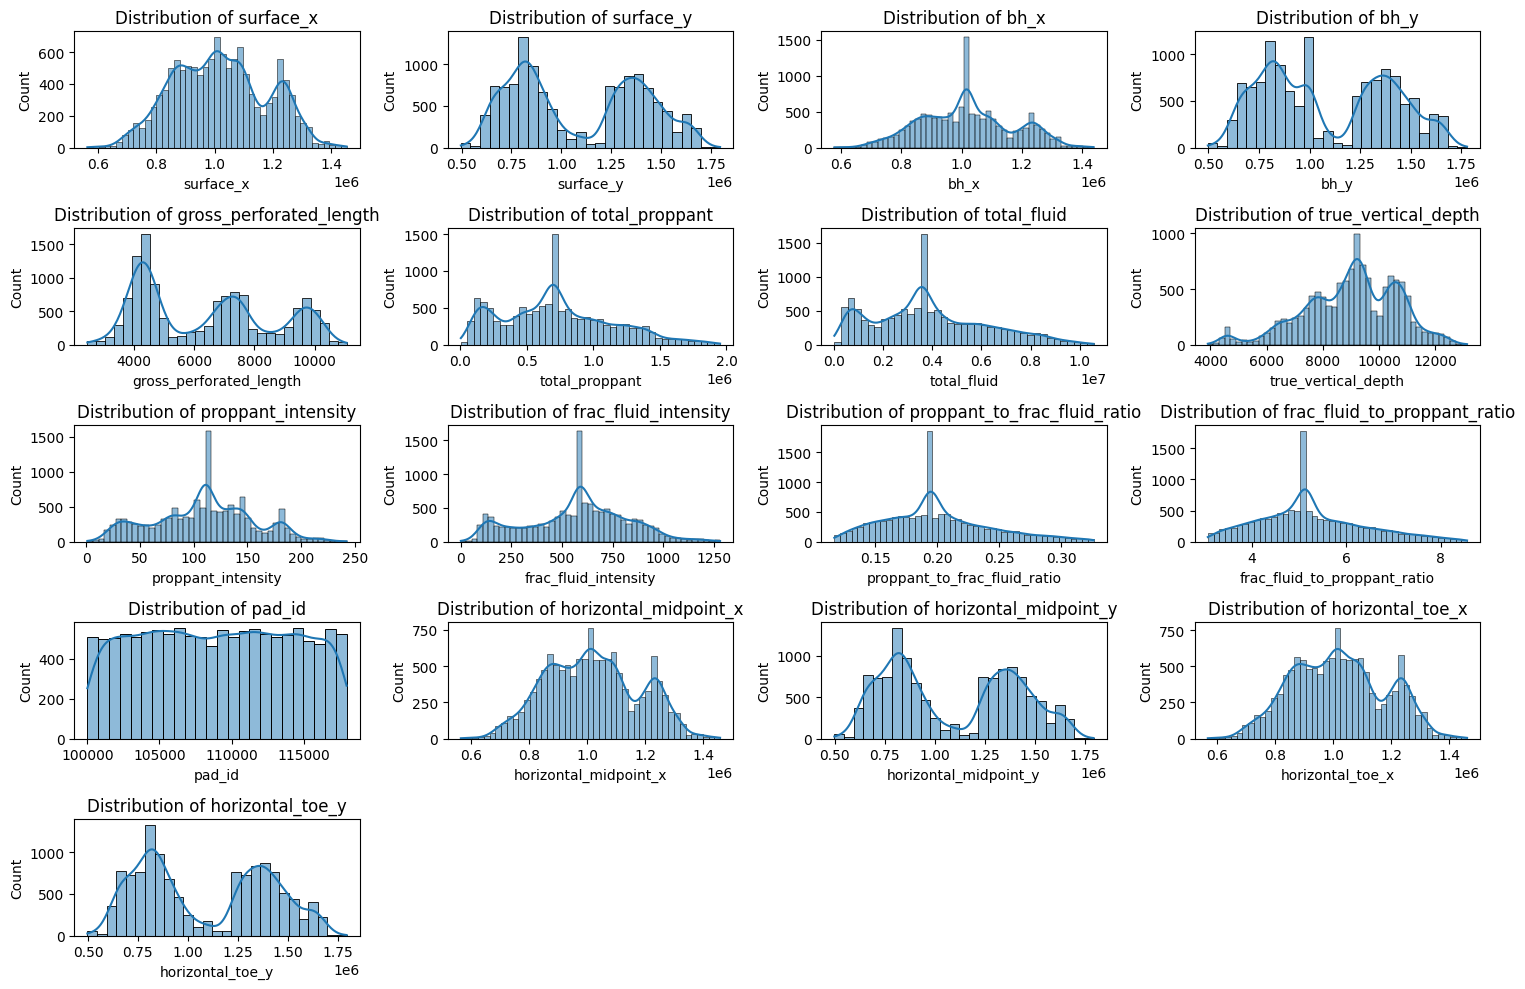

In [4]:
numerical_columns = ['surface_x','surface_y','bh_x','bh_y','gross_perforated_length','total_proppant', 'total_fluid',
                     'true_vertical_depth','proppant_intensity','frac_fluid_intensity','proppant_to_frac_fluid_ratio',
                     'frac_fluid_to_proppant_ratio','pad_id','horizontal_midpoint_x','horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y'] 

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(data_with_oilpeak_reduced[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

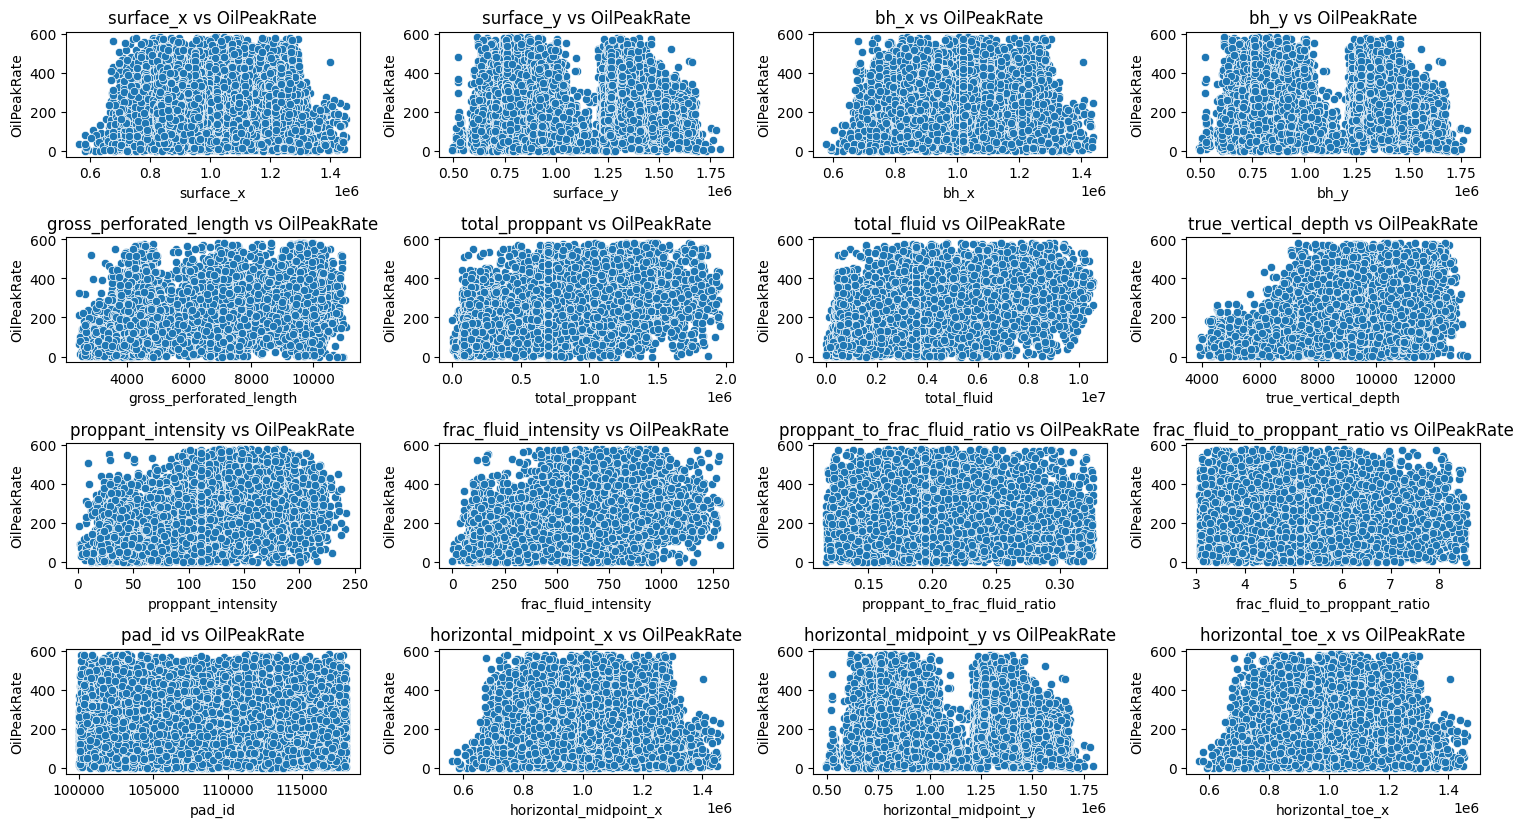

In [5]:
data_with_oilpeak_reduced = data_with_oilpeak_reduced.drop(columns=['average_stage_length','average_proppant_per_stage','average_frac_fluid_per_stage'])
numerical_columns = ['surface_x','surface_y','bh_x','bh_y','gross_perforated_length','total_proppant', 'total_fluid',
                     'true_vertical_depth','proppant_intensity','frac_fluid_intensity','proppant_to_frac_fluid_ratio',
                     'frac_fluid_to_proppant_ratio','pad_id','horizontal_midpoint_x','horizontal_midpoint_y','horizontal_toe_x','horizontal_toe_y'] 
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns[:-1], 1):
    plt.subplot(5, 4, i)
    sns.scatterplot(x=data_with_oilpeak_reduced[column], y=target_data[target_variable])
    plt.title(f'{column} vs {target_variable}')
plt.tight_layout()
plt.show()

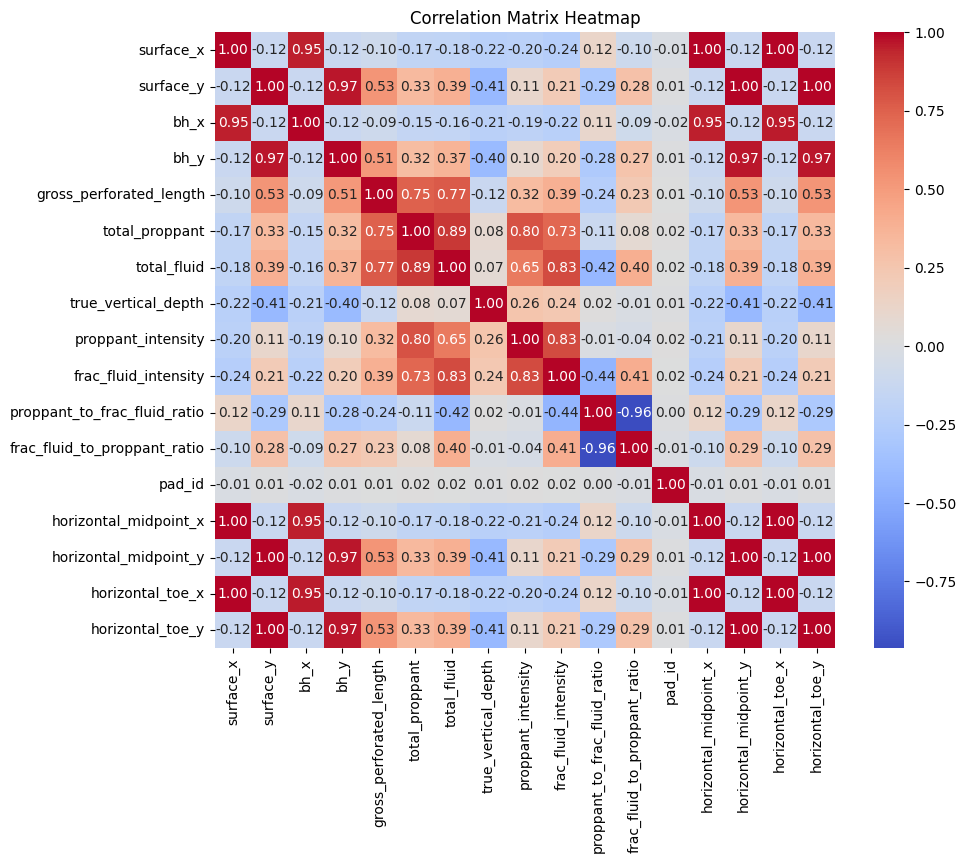

In [6]:
corr_matrix = data_with_oilpeak_reduced[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [7]:
surface_coordinates = data_with_oilpeak_reduced[['surface_x', 'surface_y']]
kmeans_surface = KMeans(n_clusters=4)
surface_clusters = kmeans_surface.fit_predict(surface_coordinates)
data_with_oilpeak_reduced['surface_cluster'] = surface_clusters

bh_coordinates = data_with_oilpeak_reduced[['bh_x', 'bh_y']]
kmeans_bh = KMeans(n_clusters=5)
bh_clusters = kmeans_bh.fit_predict(bh_coordinates)
data_with_oilpeak_reduced['bh_cluster'] = bh_clusters

mid_coordinates = data_with_oilpeak_reduced[['horizontal_midpoint_x', 'horizontal_midpoint_y']]
kmeans_mid = KMeans(n_clusters=5)
mid_clusters = kmeans_mid.fit_predict(mid_coordinates)
data_with_oilpeak_reduced['mid_clusters'] = mid_clusters

toe_coordinates = data_with_oilpeak_reduced[['horizontal_toe_x', 'horizontal_toe_y']]
kmeans_toe = KMeans(n_clusters=5)
toe_clusters = kmeans_toe.fit_predict(toe_coordinates)
data_with_oilpeak_reduced['toe_clusters'] = toe_clusters

data_with_oilpeak_reduced.head()


c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\Ferna\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

,surface_x,surface_y,bh_x,bh_y,standardized_operator_name,gross_perforated_length,number_of_stages,total_proppant,total_fluid,true_vertical_depth,...,frac_type,frac_seasoning,horizontal_midpoint_x,horizontal_midpoint_y,horizontal_toe_x,horizontal_toe_y,surface_cluster,bh_cluster,mid_clusters,toe_clusters
0,1383493.751,717329.2368,1382854.564,712767.3700,1121,3963.582677,27.0,76000.00000,3.564951e+06,8712.598425,...,Primary Frac,38.0,1383030.678,714796.3610,1382668.912,712798.4321,0,4,2,3
1,1380344.035,711916.2732,1379738.429,707860.5643,1022,3179.133858,27.0,113000.00000,5.610964e+05,8627.952756,...,Primary Frac,38.0,1379965.126,709541.7145,1379630.025,707907.6708,0,4,2,3
4,1378962.585,702623.9787,1379643.546,707204.9131,1022,3811.023622,27.0,112789.71430,6.229802e+05,8664.370079,...,Primary Frac,38.0,1379546.414,705150.7519,1379987.487,707123.7258,0,4,2,3
5,1381250.408,702293.2344,1381927.722,706874.3795,1022,3536.417323,27.0,93000.00000,5.638857e+05,8668.307087,...,Primary Frac,38.0,1382166.864,704872.4045,1382717.737,706720.3298,0,4,2,3
7,1388889.586,706536.1570,1388895.735,706578.6413,1349,4673.228346,27.0,91142.85714,6.095996e+05,8704.724409,...,Primary Frac,38.0,1389357.383,709030.8139,1389741.421,711055.9529,0,4,2,3


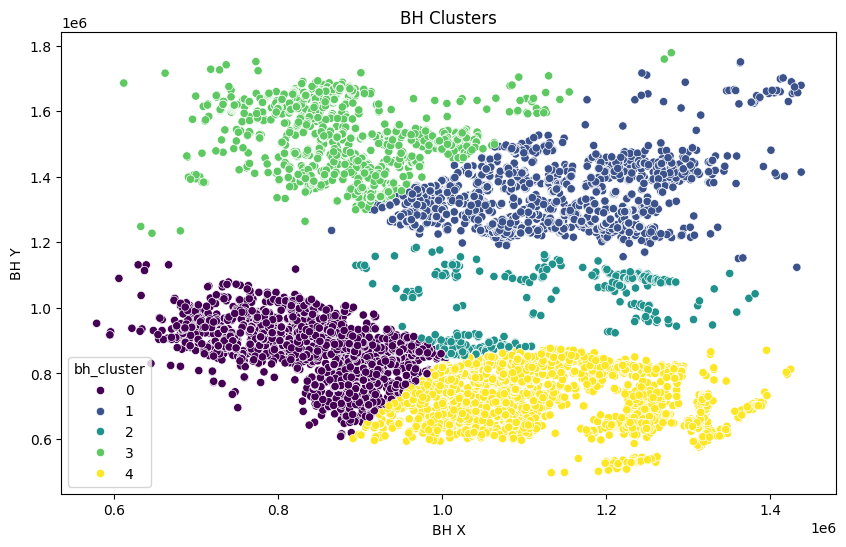

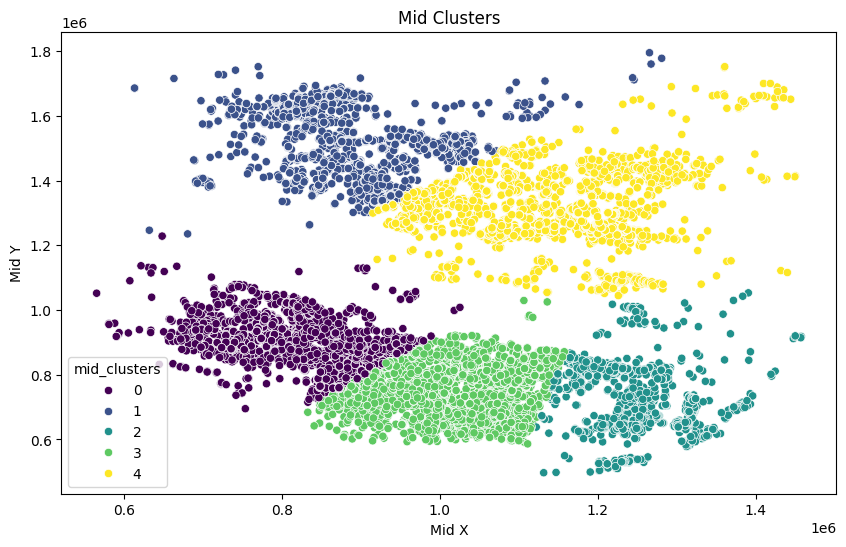

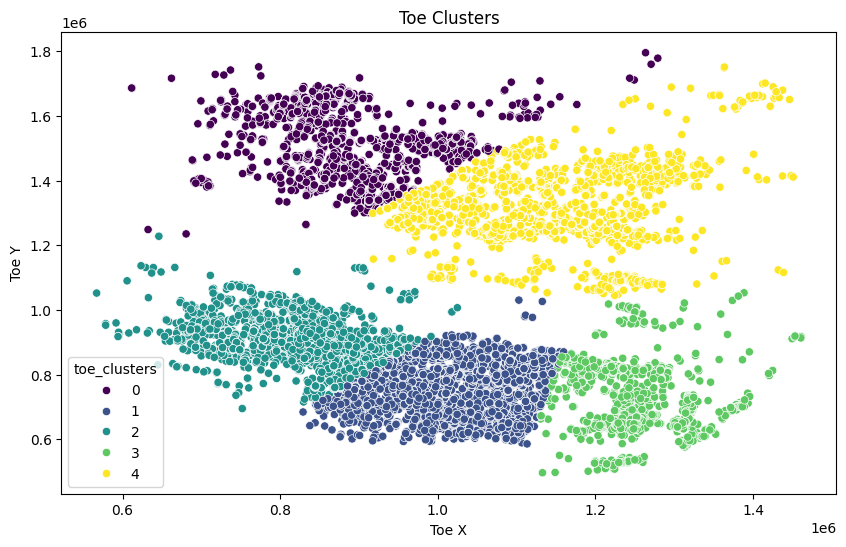

In [8]:
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x='surface_x', y='surface_y', hue='surface_cluster', data=data_with_oilpeak_reduced, palette='viridis')
# plt.title('Surface Clusters')
# plt.xlabel('Surface X')
# plt.ylabel('Surface Y')
# plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='bh_x', y='bh_y', hue='bh_cluster', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('BH Clusters')
plt.xlabel('BH X')
plt.ylabel('BH Y')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='horizontal_midpoint_x', y='horizontal_midpoint_y', hue='mid_clusters', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('Mid Clusters')
plt.xlabel('Mid X')
plt.ylabel('Mid Y')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='horizontal_toe_x', y='horizontal_toe_y', hue='toe_clusters', data=data_with_oilpeak_reduced, palette='viridis')
plt.title('Toe Clusters')
plt.xlabel('Toe X')
plt.ylabel('Toe Y')
plt.show()

In [9]:
data_with_cluster = data_with_oilpeak_reduced.drop(columns=["bh_x","bh_y","bh_cluster","mid_clusters",
                                                       "toe_clusters","horizontal_midpoint_x","horizontal_midpoint_y",
                                                       "horizontal_toe_x","horizontal_toe_y","average_proppant_per_stage","average_frac_fluid_per_stage","average_stage_length"])
data_with_cluster.info()
print(data_with_cluster.shape)

KeyError: "['average_proppant_per_stage', 'average_frac_fluid_per_stage', 'average_stage_length'] not found in axis"

In [ ]:
# x = data_with_cluster['surface_cluster']
# y = target_data[target_variable]

# plt.plot(x, y, 'o', alpha=0.2) 
# plt.xlabel(' Cluster')
# plt.ylabel('Peak Oil Rate')
# plt.title('Peak Oil Rate vs Surface Cluster')
# plt.xticks(rotation=30)
# plt.show()

In [ ]:
# data_with_cluster.to_csv('dataclust.csv', index=False)

In [ ]:
# data_with_cluster.info()
target_data.info()
target_data.head()
# target_data.to_csv('targ.csv', index=False)

# combined_data = pd.concat([data_with_cluster, target_data], axis=1)
# combined_data.head()


In [ ]:
categorical_cols = ['ffs_frac_type', 'relative_well_position', 'batch_frac_classification', 'well_family_relationship', 'frac_type']

for col in categorical_cols:
    le = LabelEncoder()
    data_with_cluster[col] = le.fit_transform(data_with_cluster[col])

Y = target_data['OilPeakRate']
X = data_with_cluster.drop(columns=['number_of_stages'])

infinite_cols = X.columns.to_series()[np.isinf(X).any()]

X.replace([np.inf, -np.inf], np.nan, inplace=True)

X = X.fillna(X.median())

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())




In [ ]:
def forward_selection(X, Y, significance_level=0.01):
    initial_features = X.columns.tolist()
    best_features = []
    
    while len(initial_features) > 0:
        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(Y, sm.add_constant(X[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < significance_level:
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features

selected_features = forward_selection(X, Y)
print("Selected features:", selected_features)

X_selected = sm.add_constant(X[selected_features])
model = sm.OLS(Y, X_selected).fit()
print(model.summary())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, Y, test_size=0.07, random_state=0)

random_forest_model = RandomForestRegressor(random_state=0)

# param_grid = {
#     'n_estimators': [100],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_

best_params = {
    'n_estimators': 100,           # Number of trees in the forest
    'max_depth': None,             # No maximum depth for the trees
    'min_samples_split': 5,        # Minimum number of samples required to split an internal node
    'min_samples_leaf': 2,         # Minimum number of samples required to be at a leaf node
    'max_features': 'sqrt',        # Number of features to consider for each split: sqrt(total_features)
    'bootstrap': True              # Use bootstrap sampling for building trees
}

print(best_params)


best_rf_model = RandomForestRegressor(**best_params, random_state=0)

# Number of folds for K-Fold Cross-Validation
num_folds = 5

# Perform cross-validation
cv_scores = cross_val_score(best_rf_model, X_selected, Y, cv=num_folds, scoring='neg_root_mean_squared_error')

# Convert the scores to positive RMSE (since they are negative)
cv_rmse_scores = -cv_scores

# Calculate the average and standard deviation of the RMSE scores
average_cv_rmse = np.mean(cv_rmse_scores)
std_dev_cv_rmse = np.std(cv_rmse_scores)

print("Average CV RMSE:", average_cv_rmse)
print("Standard Deviation of CV RMSE:", std_dev_cv_rmse)

# Fit the model on the entire training data
best_rf_model.fit(X_train, y_train)

# Predict and evaluate as before
y_train_pred = best_rf_model.predict(X_train)
y_test_pred = best_rf_model.predict(X_test)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)

# Comparison DataFrame
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
print(comparison_df.head())

In [ ]:
print(best_params)
# X_test.to_csv('lasttestx.csv', index=False)
